## About

This starter code shows how to read slides and tumor masks from the [CAMELYON16](https://camelyon17.grand-challenge.org/Data/) dataset. It will install [OpenSlide](https://openslide.org/) in Colab (the only non-Python dependency). Note that OpenSlide also includes a [DeepZoom viewer](https://github.com/openslide/openslide-python/tree/master/examples/deepzoom), shown in class. To use that, you'll need to install and run OpenSlide locally on your computer.

### Training data

The original slides and annotations are in an unusual format. I converted a bunch of them for you, so you can read them with OpenSlide as shown in this notebook. These will be uploaded for you the week of Oct 24th, at which point we'll update this notebook with a link.

Note that even with the starter code, it will take some effort to understand how to work with this data (the various zoom levels, and the coordinate system).

### Goals and grading

The goal for your project is to build a thoughtful, end-to-end prototype - not to match the accuracy from the [paper](https://arxiv.org/abs/1703.02442), and not necessarily to use all the available data. To receive an A on this work, your project should (for example):
- Use multiple zoom levels
- Use high-magnification images
- Include several visualizations of your results (both heatmaps showing predictions on individual slides, and other metrics/diagrams you design that are appropriate to communicate how well your model performs).

You are also welcome to propose a custom project of similar scope, on any topic of interest to you.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Found GPU at: /device:GPU:0


In [ ]:
# Install the OpenSlide C library and Python bindings
# After installing these libraries, use `Runtime -> restart and run all` on the menu
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 20 not upgraded.
Need to get 92.5 kB of archives.
After this operation, 268 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopenslide0 amd64 3.4.1+dfsg-2 [79.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 openslide-tools amd64 3.4.1+dfsg-2 [12.7 kB]
Fetched 92.5 kB in 0s (1,163 kB/s)
Selecting previously unselected package libopenslide0.
(Reading database ... 124016 files and directories currently installed.)
Preparing to unpack .../libopenslide0_3.4.1+dfsg

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray
import cv2

In [ ]:
# See https://openslide.org/api/python/#openslide.OpenSlide.read_region
# Note: x,y coords are with respect to level 0.
# There is an example below of working with coordinates
# with respect to a higher zoom level.

# Read a region from the slide
# Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

In [ ]:
# As mentioned in class, we can improve efficiency by ignoring non-tissue areas
# of the slide. We'll find these by looking for all gray regions.
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return list(zip(indices[0], indices[1]))

def apply_mask(im, mask, color=(255,0,0)):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked


In [ ]:
#Save 3 slide images
#Train:24 images
#Test:8 images
#Because of the performance of my computer I am not able to process more,
#So the validation dataset is also the test set
def save_screens(slide_path,tumor_mask_path,save_dir,filename):

  slide = open_slide(slide_path)
  tumor_mask = open_slide(tumor_mask_path)
  slide_image_1 = read_slide(slide,
                         x=0,
                         y=0,
                         level=5,
                         width=slide.level_dimensions[5][0],
                         height=slide.level_dimensions[5][1])
  for i in range(30):
    for j in range(30):
      grid_width=slide.level_dimensions[2][0]//30
      grid_height=slide.level_dimensions[2][1]//30
      global_grid_width=slide.level_dimensions[0][0]//30
      global_grid_height=slide.level_dimensions[0][1]//30
      start_x=i*global_grid_width
      start_y=j*global_grid_height
      sub_screen_1=read_slide(slide,
                         x=start_x,
                         y=start_y,
                         level=2,
                         width=grid_width,
                         height=grid_height)
      sub_mask_1=read_slide(tumor_mask,
                         x=start_x,
                         y=start_y,
                         level=2,
                         width=grid_width,
                         height=grid_height)[:,:,0]
      tissue_pixels = find_tissue_pixels(sub_screen_1)
      percent_tissue = len(tissue_pixels) / float(grid_width * grid_height) * 100
      tumor_percent=sub_mask_1.flatten().sum()/len(sub_mask_1.flatten())
      label=0
      if(tumor_percent>0):
        label=1
      if percent_tissue>40 or tumor_percent>0.1:
        grid_width_lv3=slide.level_dimensions[3][0]//20
        grid_height_lv3=slide.level_dimensions[3][1]//20
        global_grid_width_lv3=slide.level_dimensions[0][0]//20
        global_grid_height_lv3=slide.level_dimensions[0][1]//20
        center_x=start_x+global_grid_width//2
        center_y=start_y+global_grid_height//2
        x_min=center_x-global_grid_width_lv3//2
        x_max=center_x+global_grid_width_lv3//2
        y_min=center_y-global_grid_height_lv3//2
        y_max=center_y+global_grid_height_lv3//2
        new_start_x=x_min
        new_start_y=y_min
        if(x_min<0):
          new_start_x=0
        if(x_max>=slide.level_dimensions[0][0]):
          new_start_x=slide.level_dimensions[0][0]-1-global_grid_width_lv3
        if(y_min<0):
          new_start_y=0
        if(y_max>slide.level_dimensions[0][1]):
          new_start_y=slide.level_dimensions[0][1]-1-global_grid_height_lv3
        sub_screen_2=read_slide(slide,
                         x=new_start_x,
                         y=new_start_y,
                         level=3,
                         width=grid_width_lv3,
                         height=grid_height_lv3)
        grid_width_lv4=slide.level_dimensions[4][0]//10
        grid_height_lv4=slide.level_dimensions[4][1]//10
        global_grid_width_lv4=slide.level_dimensions[0][0]//10
        global_grid_height_lv4=slide.level_dimensions[0][1]//10
        x_min=center_x-global_grid_width_lv4//2
        x_max=center_x+global_grid_width_lv4//2
        y_min=center_y-global_grid_height_lv4//2
        y_max=center_y+global_grid_height_lv4//2
        new_start_x=x_min
        new_start_y=y_min
        if(x_min<0):
          new_start_x=0
        if(x_max>=slide.level_dimensions[0][0]):
          new_start_x=slide.level_dimensions[0][0]-1-global_grid_width_lv4
        if(y_min<0):
          new_start_y=0
        if(y_max>slide.level_dimensions[0][1]):
          new_start_y=slide.level_dimensions[0][1]-1-global_grid_height_lv4
        sub_screen_3=read_slide(slide,
                          x=new_start_x,
                          y=new_start_y,
                          level=4,
                          width=grid_width_lv4,
                          height=grid_height_lv4)
        res1=cv2.resize(sub_screen_1,dsize=(512,512))
        res2=cv2.resize(sub_screen_2,dsize=(512,512))
        res3=cv2.resize(sub_screen_3,dsize=(512,512))
        plt.imsave(save_dir+"screen1/"+filename[:-4]+"_"+str(i)+'_'+str(j)+"_screen1_"+str(label)+".jpg",res1)
        plt.imsave(save_dir+"screen2/"+filename[:-4]+"_"+str(i)+'_'+str(j)+"_screen2_"+str(label)+".jpg",res2)
        plt.imsave(save_dir+"screen3/"+filename[:-4]+"_"+str(i)+'_'+str(j)+"_screen3_"+str(label)+".jpg",res3)











In [ ]:
import os
pth_tumor='/content/drive/MyDrive/tumor_files_test/'
pth_mask='/content/drive/MyDrive/mask_files_test/'
out_dir='/content/drive/MyDrive/tumor_images_testing/'
folder = os.fsencode(pth_tumor)
for file in os.listdir(folder):
    filename = os.fsdecode(file)
    pth_tumor_filename=pth_tumor+filename
    pth_mask_filename=pth_mask+filename[:-4]+"_mask.tif"
    save_screens(pth_tumor_filename,pth_mask_filename,out_dir,filename)


In [ ]:
import os
pth_tumor='/content/drive/MyDrive/tumor_files_train/'
pth_mask='/content/drive/MyDrive/mask_files_train/'
out_dir='/content/drive/MyDrive/tumor_images_training/'
folder = os.fsencode(pth_tumor)
for file in os.listdir(folder):
    filename = os.fsdecode(file)
    pth_tumor_filename=pth_tumor+filename
    pth_mask_filename=pth_mask+filename[:-4]+"_mask.tif"
    save_screens(pth_tumor_filename,pth_mask_filename,out_dir,filename)

In [ ]:
# label imbalanced as expected
read_dir='/content/drive/MyDrive/tumor_images_testing/screen3'
folder = os.fsencode(read_dir)
num_0=0
num_1=0
for file in os.listdir(folder):
  filename=os.fsdecode(file)
  if filename[-5]=='1':
    num_1+=1
  else:
    num_0+=1
print(num_0)
print(num_1)

651
104


In [ ]:
#generate dataset
import os
read_dir='/content/drive/MyDrive/tumor_images_training/screen1/'
folder = os.fsencode(read_dir)
dset=[]
for file in os.listdir(folder):
  filename=os.fsdecode(file)
  pth_screen1_file=read_dir+filename
  pth_screen2_file=read_dir[:-2]+"2/"+filename[:-7]+"2"+filename[-6:]
  pth_screen3_file=read_dir[:-2]+"3/"+filename[:-7]+"3"+filename[-6:]
  img_lst=[]
  img_lst.append(pth_screen1_file)
  img_lst.append(pth_screen2_file)
  img_lst.append(pth_screen3_file)
  dset.append(img_lst)
read_dir='/content/drive/MyDrive/tumor_images_testing/screen1/'
folder = os.fsencode(read_dir)
dset_test=[]
for file in os.listdir(folder):
  filename=os.fsdecode(file)
  pth_screen1_file=read_dir+filename
  pth_screen2_file=read_dir[:-2]+"2/"+filename[:-7]+"2"+filename[-6:]
  pth_screen3_file=read_dir[:-2]+"3/"+filename[:-7]+"3"+filename[-6:]
  img_lst=[]
  img_lst.append(pth_screen1_file)
  img_lst.append(pth_screen2_file)
  img_lst.append(pth_screen3_file)
  dset_test.append(img_lst)
def generator():
  for s1,s2,s3 in dset:
    yield (cv2.imread(s1),cv2.imread(s1),cv2.imread(s1)), np.array([int(s1[-5])])
dataset = tf.data.Dataset.from_generator(generator,((tf.int64, tf.int64,tf.int64),tf.int64),(((512,512,3),(512,512,3),(512,512,3)),(1)))
dataset = dataset.batch(8)
def generator_test():
  for s1,s2,s3 in dset_test:
    yield (cv2.imread(s1),cv2.imread(s1),cv2.imread(s1)), np.array([int(s1[-5])])
dataset_test = tf.data.Dataset.from_generator(generator_test,((tf.int64, tf.int64,tf.int64),tf.int64),(((512,512,3),(512,512,3),(512,512,3)),(1)))
dataset_test = dataset_test.batch(8)

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras import Input, Model
from keras.layers import Dense, Flatten, Concatenate
from keras.activations import relu
from tensorflow.keras.applications.resnet_v2 import ResNet101V2
# Multiple inputs
in1 = Input(shape=(512,512,3))
in2 = Input(shape=(512,512,3))
in3 = Input(shape=(512,512,3))

# InceptionV3 output
cnn = InceptionV3(input_shape=(512,512,3),include_top=False)
cnn2 = InceptionV3(input_shape=(512,512,3),include_top=False)
cnn3 = InceptionV3(input_shape=(512,512,3),include_top=False)
#cnn = ResNet101V2(shape=(512,512,3),include_top=False,weights=None)
#cnn2 = ResNet101V2(shape=(512,512,3),include_top=False,weights=None)
#cnn3 = ResNet101V2(shape=(512,512,3),include_top=False,weights=None)
cnn2._name = cnn2.name + str("_2")
cnn3._name = cnn3.name + str("_3")
#cnn.summary()

out1 = cnn(in1)
out2 = cnn2(in2)
out3 = cnn3(in3)

# Flattening the output for the dense layer
fout1 = Flatten()(out1)
fout2 = Flatten()(out2)
fout3 = Flatten()(out3)
merged = tf.keras.layers.concatenate([fout1, fout2, fout3])
output = Dense(1, activation='sigmoid')(merged)
# Creating the model
model = Model(inputs=[in1,in2,in3], outputs=output)
model.summary()

87910968/87910968 [==============================] - 5s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_3 (InputLayer)           [(None, 512, 512, 3  0           []                               
                             

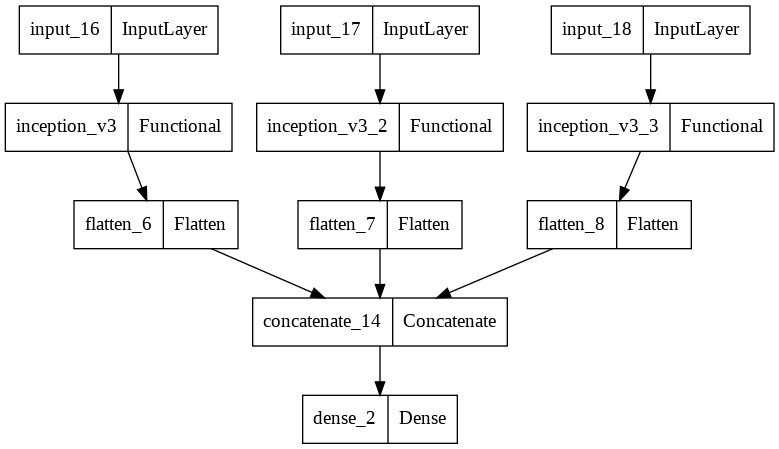

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model,to_file='model.png')

In [ ]:
#Data Augmentation
from tensorflow.keras import layers
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(height_factor=(-0.3, 0.3),width_factor=(-0.3, 0.3)),
])
aug_ds = dataset.map(
  lambda x, y: ((data_augmentation(x[0], training=True),data_augmentation(x[1], training=True),data_augmentation(x[2], training=True)), y))

In [ ]:
#Lower learning_rate such that model converges
opt=tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['AUC'])

In [ ]:

hist=model.fit(aug_ds, epochs=40,validation_data=dataset_test)


In [ ]:
model.save('/content/drive/MyDrive/Models/')

In [ ]:
import tensorflow as tf
# I trained different models with different seeds, this is a good one among them
model = tf.keras.models.load_model('/content/drive/MyDrive/Models/')

In [ ]:
y_test_pred = model.predict(dataset_test)

95/95 [==============================] - 77s 586ms/step


In [ ]:
y_pred=model.predict(dataset)

285/285 [==============================] - 609s 2s/step


In [ ]:
y_label_true=np.array([int(dset[i][0][-5]) for i in range(len(dset))])

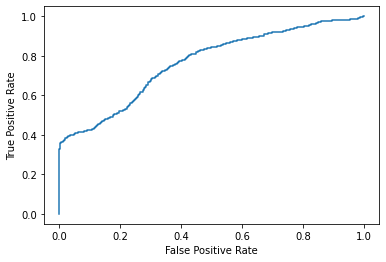

0.7639089110821633

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
fpr, tpr, threshs = roc_curve(y_label_true,y_pred)

#create ROC curve and calculate AUC
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
roc_auc_score(y_label_true,y_pred)

In [ ]:
y_test_label_true=np.array([int(dset_test[i][0][-5]) for i in range(len(dset_test))])

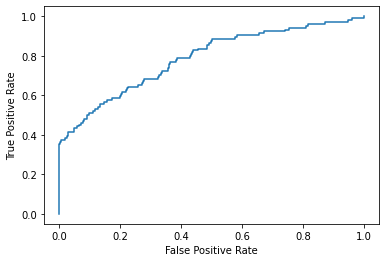

0.7861721611721613

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
fpr_test, tpr_test, threshs_test = roc_curve(y_test_label_true,y_test_pred)

#create ROC curve and calculate AUC
plt.plot(fpr_test,tpr_test)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
roc_auc_score(y_test_label_true,y_test_pred)

From Both AUC curve we can see that picking a threshold making the TPR=0.8, FPR=0.4 might be a good choice, since we care more about TPR for tumor detection, we want True cases to be detected as many as possible

In [ ]:
threshs[np.where(np.isclose(tpr,0.8,rtol=0.001))[0]]

array([0.16329296, 0.16278134], dtype=float32)

In [ ]:
threshs_test[np.where(np.isclose(tpr_test,0.8,rtol=0.01))[0]]

array([0.15124042, 0.15082127, 0.1505622 , 0.15020046], dtype=float32)

In [ ]:
#It can be seen a threshold of 0.15-0.16 would be a good choice,
#here I choose 0.16 since it is result from test set
#If there is a validation set and a test set, then I would use a threshold from validation set
#Here I will use the threshold from training set to avoid data leakage

In [ ]:
final_thresh=0.16278125
y_test_pred_label = np.where(y_test_pred.flatten() > final_thresh, 1, 0)

In [ ]:
slide_info=[]
files={}
for i in range(len(dset_test)):
  img=dset_test[i]
  orig_file_num=img[0][58:61]
  slide_coordinate=(int(img[0][62:].split('_')[0]),int(img[0][62:].split('_')[1]))
  #label=int(img[0][-5])
  #label=y_label_true[i]
  label=y_test_pred_label[i]
  slide_info.append((orig_file_num,slide_coordinate,label))
  if orig_file_num not in files:
    files[orig_file_num]=[(slide_coordinate,label)]
  elif label==1:
    files[orig_file_num].append((slide_coordinate,label))


In [ ]:
from sklearn.metrics import fbeta_score
print("F5 Score of Label is:")
print(fbeta_score(y_test_label_true, y_test_pred_label, beta=5))

F5 Score of Label is:
0.7232021709633649


F5 Score of tumor084: 0.6123107908698153
F5 Score of tumor035: 0.0
F5 Score of tumor040: 0.008094248362133055
F5 Score of tumor101: 0.9047732742193846
F5 Score of tumor064: 0.8053035193737371
F5 Score of tumor002: 0.0
F5 Score of tumor045: 0.13900689408143022
F5 Score of tumor048: 0.0


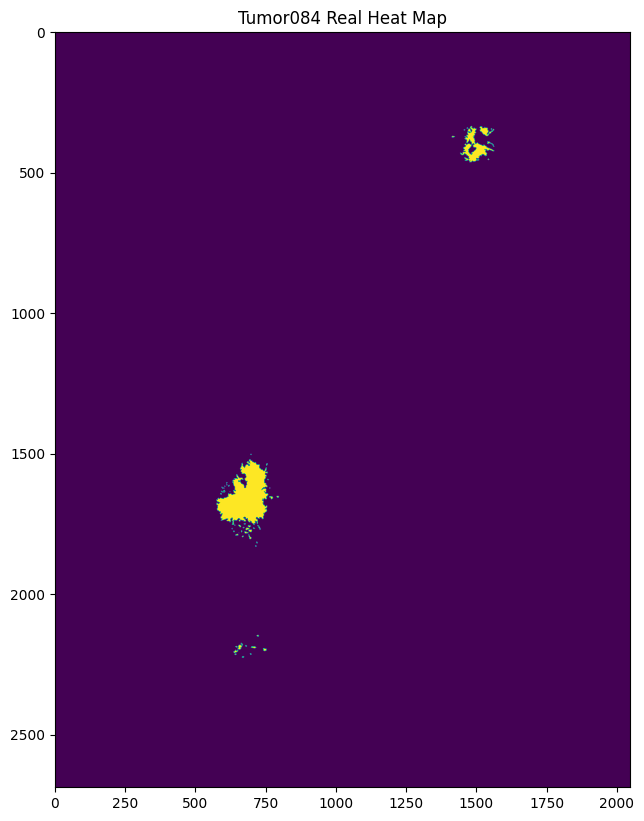

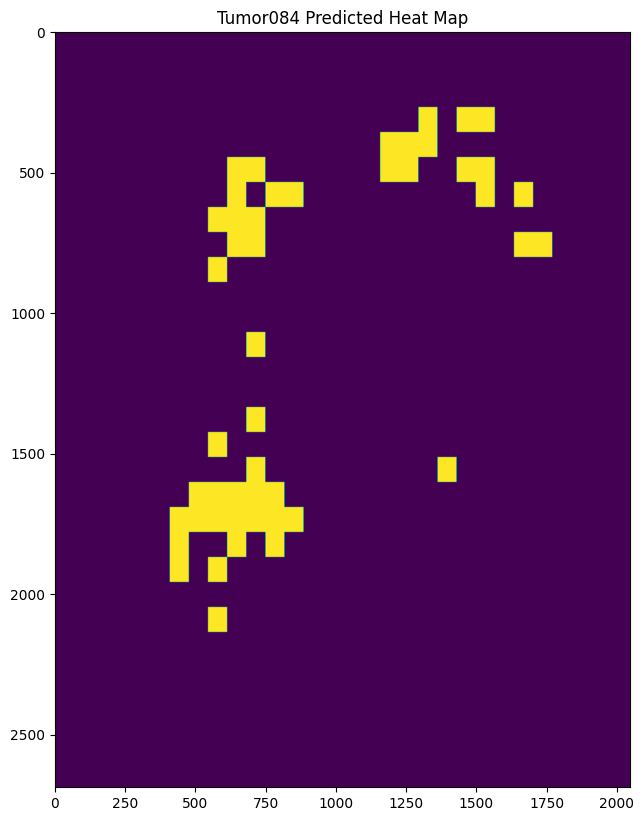

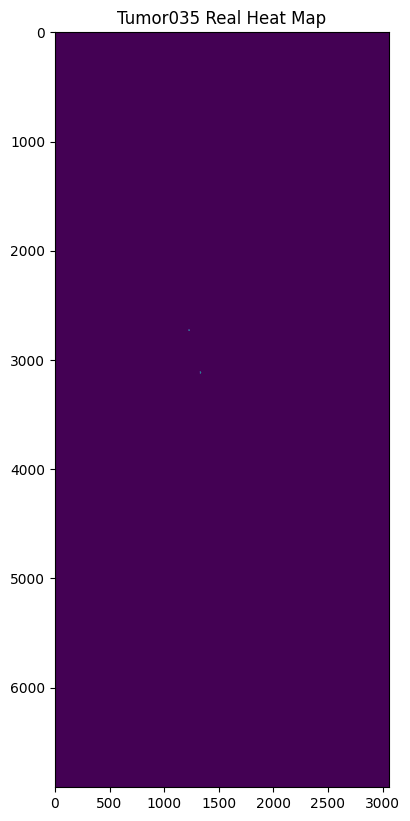

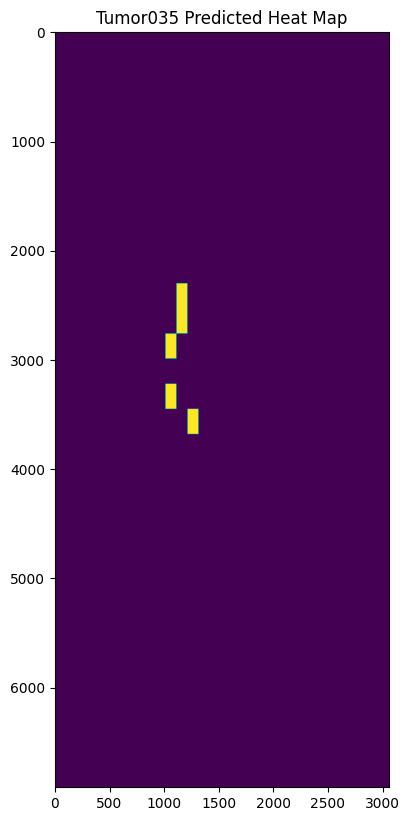

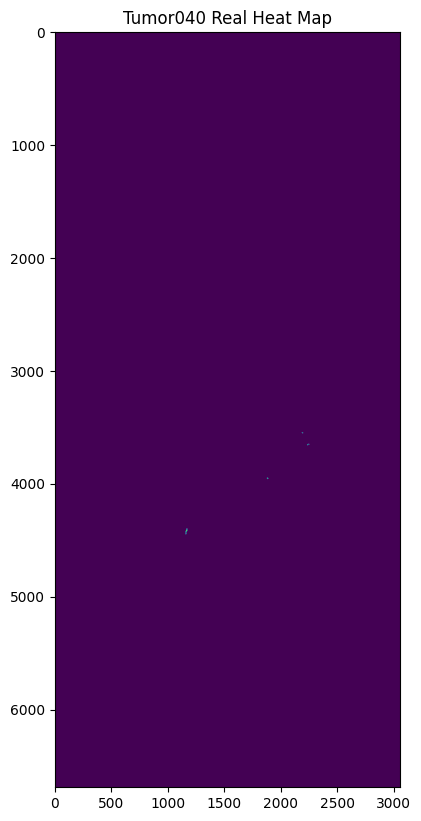

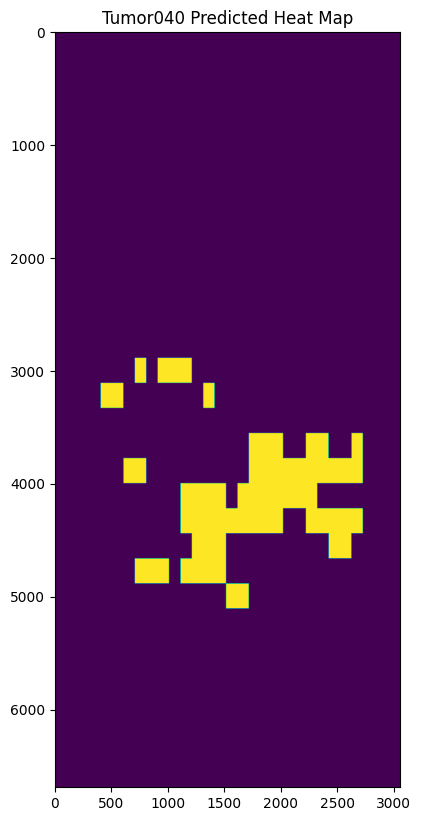

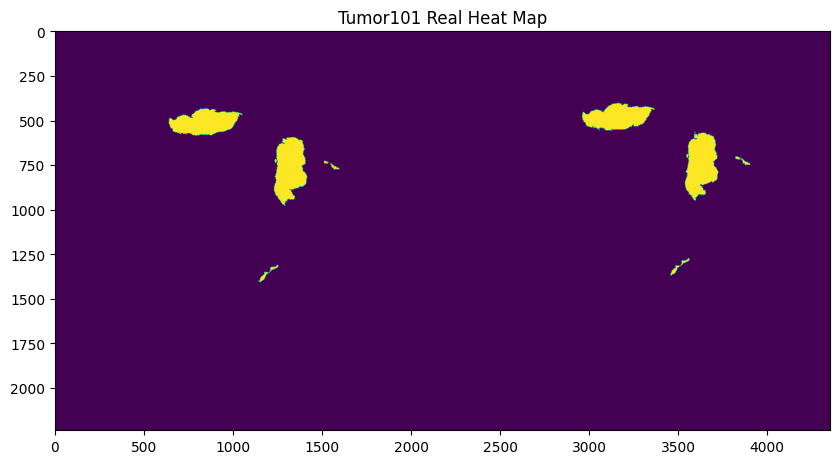

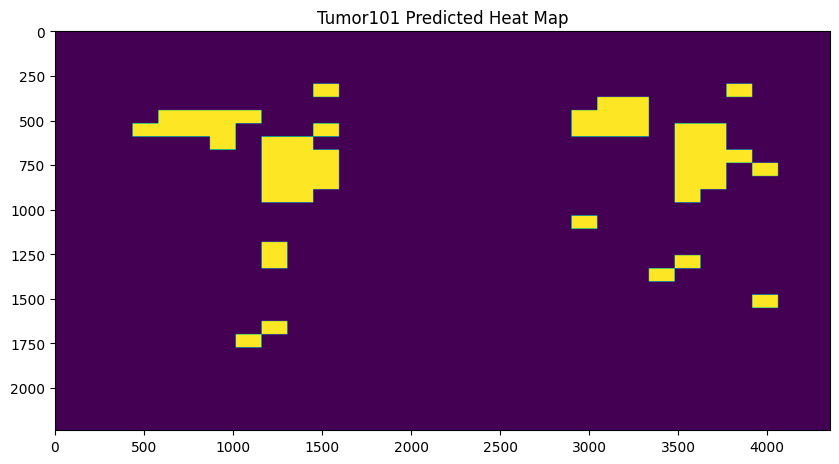

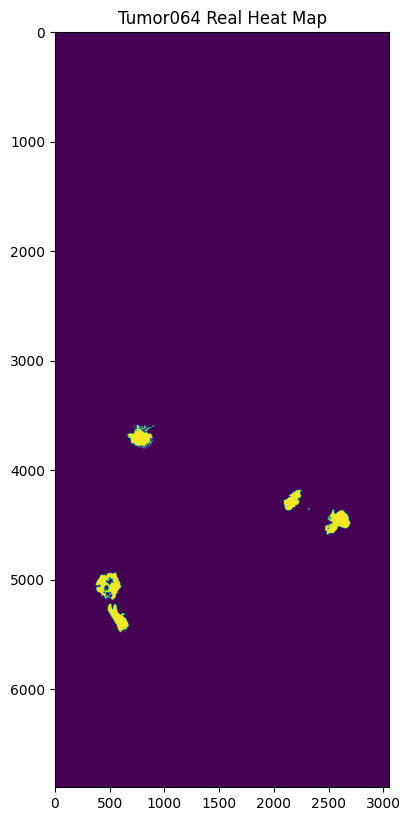

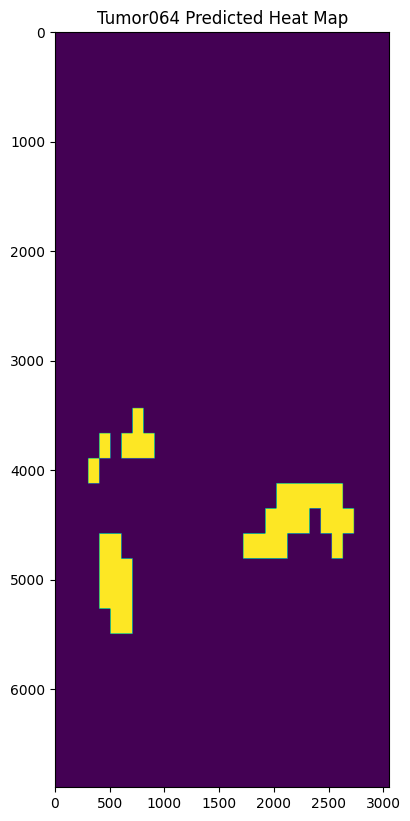

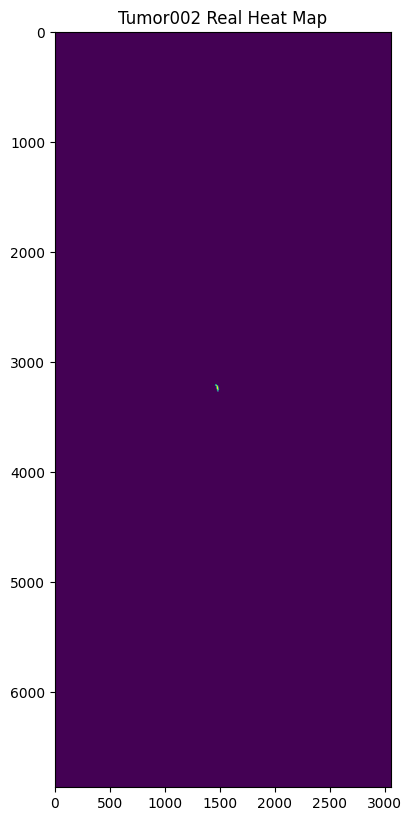

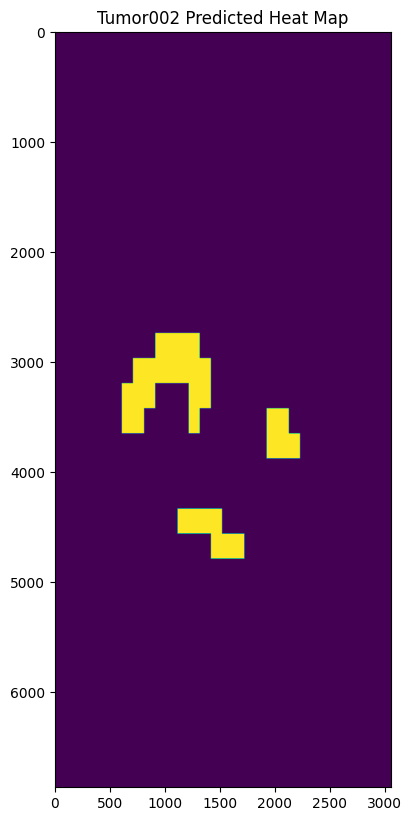

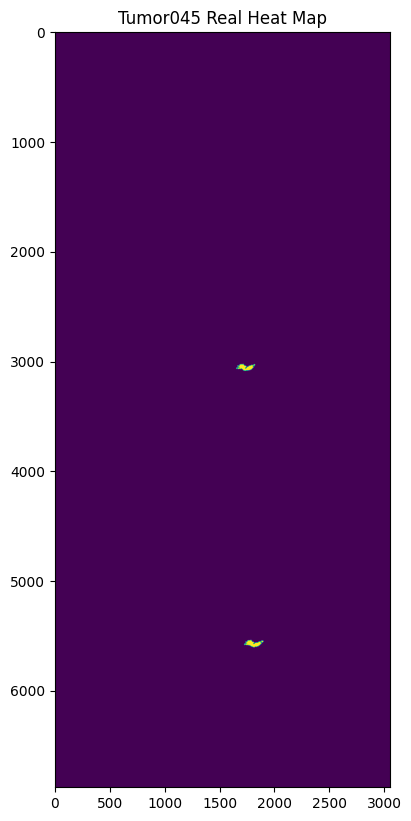

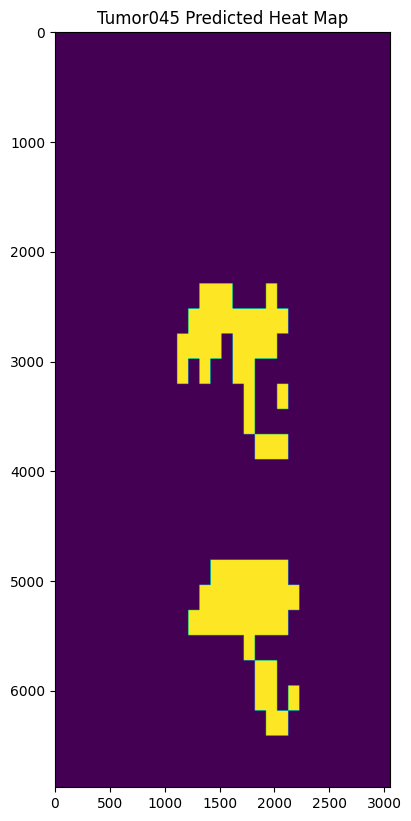

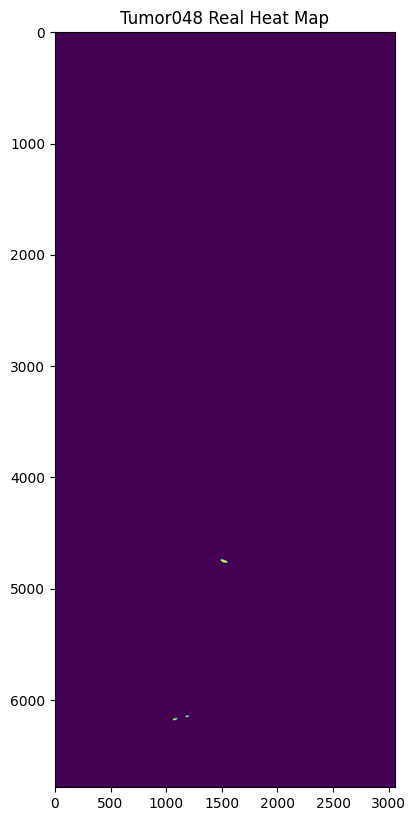

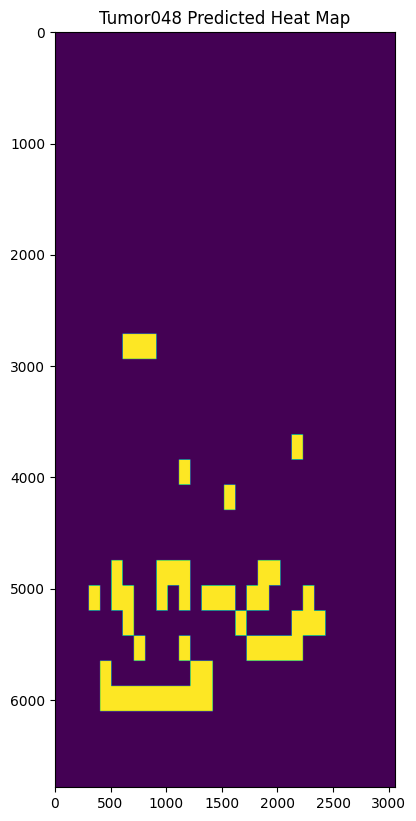

In [ ]:
#Heat Map and image-wise result
#Note that many images don't have tumor pixels or very small area
for key in files:
  coords=files[key]
  slide_path = '/content/drive/MyDrive/tumor_files_test/tumor_'+key+'.tif'
  tumor_mask_path = '/content/drive/MyDrive/mask_files_test/tumor_'+key+'_mask.tif'
  slide=open_slide(slide_path)
  tumor_mask = open_slide(tumor_mask_path)
  mask_image = read_slide(tumor_mask,
                        x=0,
                        y=0,
                        level=5,
                        width=slide.level_dimensions[5][0],
                        height=slide.level_dimensions[5][1])
  mask_image = mask_image[:,:,0]
  x_range=slide.level_dimensions[5][1]
  y_range=slide.level_dimensions[5][0]
  grid_x=x_range//30
  grid_y=y_range//30
  new_hm=np.zeros(x_range*y_range).reshape(x_range,y_range)
  for coord,label in coords:
    if label==1:
      x=coord[0]
      y=coord[1]
      for i in range(grid_x*y,grid_x*(y+1)):#Coordinate system of image and open slide is different
        for j in range(grid_y*x,grid_y*(x+1)):
          new_hm[i][j]=1
  print("F5 Score of tumor"+key+": "+str(fbeta_score(mask_image.flatten(), new_hm.flatten(), beta=5)))
  plt.figure(figsize=(10,10), dpi=100)
  plt.title("Tumor"+key+" Real Heat Map")

  plt.imshow(mask_image)

  plt.figure(figsize=(10,10), dpi=100)
  plt.title("Tumor"+key+" Predicted Heat Map")
  plt.imshow(new_hm)



